In [450]:
import sys
import math
import pandas as pd
import numpy as np
import causalimpact as ci
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import csv

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import reader_writer
from Utilities import query_engines

rw = reader_writer.Reader_Writer()

# SPM Group creator

**Context**
<br>
After we carry out a test, we use a method known as synthetic control to decide if the results of the test are significant.
<br>
<br>
In this case, we will use the post-treatment period from the synthetic control (group configuration) for the pre-test period of this analysis. This is because the group structure was chosen specifically to best predict the post-treatment period of the first test (group configuration).
<br>
<br>
**Approach**
For synthetic control analysis I use the following convetions:
- We use the group structure defined in the earlier group set up phase.
- The post period in the group set up phase should be used as the pre-test period in the test analysis.

Read .csv file from config_prod file for d_stores

In [451]:
# Params
group_name = ['CARR_ES', 'CARR_IT', 'CARR_GE', 'CONT_PT', 'NIKO_GE']

# Read csv
d_stores = rw.csv_read_file('config.csv')
cond = d_stores['group_name'].isin(group_name)
d_stores = d_stores[cond][['country_code','group_name','store_address_id']]
d_stores

#Report
print('There are {} distinct countries'.format(d_stores['country_code'].nunique()))
print('There are {} distinct group names'.format(d_stores['group_name'].nunique()))
print('There are {} distinct store addresses'.format(d_stores['store_address_id'].nunique()))

grouped_stores = d_stores.groupby('group_name')['store_address_id'].nunique().reset_index()
grouped_stores

There are 4 distinct countries
There are 5 distinct group names
There are 949 distinct store addresses


,group_name,store_address_id
0,CARR_ES,262
1,CARR_GE,29
2,CARR_IT,408
3,CONT_PT,193
4,NIKO_GE,57


Query the information in d_pna to enrich the d_stores

In [452]:
start_date = '2023-06-19'; end_date = '2023-07-08'

# All store addresses in d_stores in XXX1,XXX2,XXX3... format
store_addresses = ",".join(str(val) for val in d_stores['store_address_id'].unique().tolist())

# Params
params = [
    {'name':'store_addresses', 'value':store_addresses}
    ,{'name':'start_date', 'value':start_date}
    ,{'name':'end_date', 'value':end_date}
]

# Query d_pna
query = query_engines.QueryEngines(
    query='SPM/SPM_synthetic.sql', 
    del1='--v3', 
    del2='--end_v3',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_pna = query.query_run_starbust()

# TO BE INCORPORTATED
# Query d_p_avail
query = query_engines.QueryEngines(
    query='SPM/SPM_synthetic.sql', 
    del1='--prod_availability', 
    del2='--end_prod_availability',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_p_avail = query.query_run_starbust()
#Report
print('FROM d_pna')
print('There are {} distinct dates'.format(d_pna['order_descriptors.order_activated_local_date'].nunique()))
print('There are {} distinct store_addresses'.format(d_pna['order_descriptors.store_address_id'].nunique()))
print('There are {} distinct number of products_with_pna'.format(d_pna['number_of_products_with_pna'].sum()))
print('There are {} distinct number of placed products'.format(d_pna['number_of_placed_products'].sum()))
print('There are {} distinct number of orders'.format(d_pna['number_of_orders'].sum()))
print('-----')
print('FROM d_p_avail')
print('There are {} distinct dates'.format(d_p_avail['product_availability.snapshot_date_date'].nunique()))
print('There are {} distinct store_addresses'.format(d_p_avail['store_address_id'].nunique()))

c:\Users\Jordi Cremades\Documents\Repository\Utilities\query_engines.py:154: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


c:\Users\Jordi Cremades\Documents\Repository\Utilities\query_engines.py:154: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


FROM d_pna
There are 20 distinct dates
There are 790 distinct store_addresses
There are 57379 distinct number of products_with_pna
There are 756192 distinct number of placed products
There are 98113 distinct number of orders
-----
FROM d_p_avail
There are 20 distinct dates
There are 898 distinct store_addresses


Merge the queried info from d_pna to d_stores dataframe

In [453]:
# We only keep the stores that had sales with an inner join
d_inner = pd.merge(d_stores,d_pna
                      ,left_on=['store_address_id']
                      ,right_on=['order_descriptors.store_address_id']
                      ,how='inner').drop('order_descriptors.store_address_id', axis=1)

# Rename the date column
d_inner = d_inner.rename(columns={'order_descriptors.order_activated_local_date': 'date'})

# Report
d_inner.groupby(by='group_name').agg({
    'store_address_id': 'nunique'
    ,'date': ['min', 'max', 'nunique']
    ,'number_of_products_with_pna': 'sum'
    ,'number_of_placed_products': 'sum'
    ,'number_of_orders':'sum'
    ,'number_of_delivered_orders':'sum'
    ,'total_quantity_placed':'sum'
    ,'products_value_placed':'sum'
})

store_address_id        date                      \
                    nunique         min         max nunique   
group_name                                                    
CARR_ES                 236  2023-06-19  2023-07-08      20   
CARR_GE                  22  2023-06-19  2023-07-08      20   
CARR_IT                 313  2023-06-19  2023-07-08      20   
CONT_PT                 179  2023-06-19  2023-07-08      20   
NIKO_GE                  40  2023-06-19  2023-07-08      20   

           number_of_products_with_pna number_of_placed_products  \
                                   sum                       sum   
group_name                                                         
CARR_ES                          17757                    243458   
CARR_GE                           1973                     41126   
CARR_IT                          16142                    199990   
CONT_PT                          19416                    218477   
NIKO_GE                           2091                     53141   

           number_of_orders number_of_delivered_orders total_quantity_placed  \
                        sum                        sum                   sum   
group_name                                                                     
CARR_ES               29556                      28670                372563   
CARR_GE                5723                       5528                 64166   
CARR_IT               26380                      25257                278540   
CONT_PT               27559                      26027                276173   
NIKO_GE                8895                       8389                 87367   

           products_value_placed  
                             sum  
group_name                        
CARR_ES             1.053332e+06  
CARR_GE             1.135224e+05  
CARR_IT             9.226297e+05  
CONT_PT             7.672276e+05  
NIKO_GE             1.269903e+05

In [454]:
d_stores

,country_code,group_name,store_address_id
0,ES,CARR_ES,111878
1,ES,CARR_ES,127398
2,ES,CARR_ES,127400
3,ES,CARR_ES,127402
4,ES,CARR_ES,127403
...,...,...,...
10616,ES,CARR_ES,580054
10617,ES,CARR_ES,161660
10618,ES,CARR_ES,544772
10619,ES,CARR_ES,587434


In [455]:
d_inner_prod_avail = pd.merge(d_stores,d_p_avail
                      ,left_on=['store_address_id']
                      ,right_on=['store_address_id']
                      ,how='inner')
d_inner_prod_avail['group_name']

0        CARR_ES
1        CARR_ES
2        CARR_ES
3        CARR_ES
4        CARR_ES
          ...   
15035    CARR_ES
15036    CARR_ES
15037    CARR_ES
15038    CARR_ES
15039    CARR_ES
Name: group_name, Length: 15040, dtype: object

## Analysis CARR_ES

In [456]:
# Params
group_name = 'CARR_ES'
file_csv_group_name = 'CARR_ES.csv'
start_pre = "2023-06-19"
end_pre = "2023-07-03"
start_post = "2023-07-04"
end_post = "2023-07-08"

Join with info of the d_inner, which is enriched data from queries

In [457]:
# Load groups info 
d_groups = rw.csv_read_file(file_csv_group_name)
# PNA
d_filtered = d_inner[d_inner['group_name'] == group_name] # Only keep the filtered group name
d_filtered_w_groups = pd.merge(d_filtered, d_groups, on='store_address_id') # Add the groups info
# Prod availability
d_filtered_prod_avail = d_inner_prod_avail[d_inner_prod_avail['group_name'] == group_name] # Only keep the filtered group name
d_filtered_prod_avail_w_groups = pd.merge(d_filtered_prod_avail, d_groups, on='store_address_id') # Add the groups info

# Report
print('There are {} distinct store_addresses for {} in d_inner'.format(d_filtered['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_groups'.format(d_filtered_w_groups['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses for {} in d_inner_prod_avail'.format(d_filtered_prod_avail['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_prod_avail_groups'.format(d_filtered_prod_avail_w_groups['store_address_id'].nunique(),group_name))


There are 236 distinct store_addresses for CARR_ES in d_inner
There are 236 distinct store_addresses fror CARR_ES in d_inner_groups
There are 261 distinct store_addresses for CARR_ES in d_inner_prod_avail
There are 243 distinct store_addresses fror CARR_ES in d_inner_prod_avail_groups


Prepare the df_synth_format for the synthetic control with all needed variables in groupby format

In [458]:
# Data period range
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

# Group by and compute the metrics for synth format
df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'
                                                        ,'number_of_placed_products'
                                                        ,'number_of_orders'
                                                        ,'number_of_delivered_orders'
                                                        ,'total_quantity_placed'
                                                        ,'products_value_placed'
                                                        ].sum().reset_index()

df_synth_format['perc_products_pna'] = df_synth_format['number_of_products_with_pna']/df_synth_format['number_of_placed_products']
df_synth_format['avg_UIPO'] = df_synth_format['number_of_placed_products']/df_synth_format['number_of_orders']
df_synth_format.head()

C:\Users\Jordi Cremades\AppData\Local\Temp\ipykernel_12548\280939351.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'


,date,Group,number_of_products_with_pna,number_of_placed_products,number_of_orders,number_of_delivered_orders,total_quantity_placed,products_value_placed,perc_products_pna,avg_UIPO
0,2023-06-19,Control,234,2817,339,327,4287,9305.94,0.083067,8.309735
1,2023-06-19,Treat,707,8596,986,951,12870,27631.88,0.082248,8.718053
2,2023-06-20,Control,181,2368,284,277,3639,7545.97,0.076436,8.338028
3,2023-06-20,Treat,564,8079,991,964,12675,26936.37,0.069811,8.152371
4,2023-06-21,Control,167,2245,293,284,3415,7801.72,0.074388,7.662116


Eye check of the df_synth_fromat

In [459]:
eye_check_columns = [
    'number_of_products_with_pna'
    ,'number_of_placed_products'
    ,'number_of_orders'
    ,'number_of_delivered_orders'
    ,'total_quantity_placed'
    ,'products_value_placed'
    ,'perc_products_pna'
    ,'avg_UIPO'
] 
df_eye_check = df_synth_format.pivot_table(index='date', columns='Group', values=eye_check_columns)
df_eye_check

avg_UIPO           number_of_delivered_orders        \
Group        Control     Treat                    Control Treat   
date                                                              
2023-06-19  8.309735  8.718053                        327   951   
2023-06-20  8.338028  8.152371                        277   964   
2023-06-21  7.662116  7.991543                        284   916   
2023-06-22  7.558621  7.662398                        276   834   
2023-06-23  7.394410  7.979937                        311   925   
2023-06-24  8.098795  8.380952                        405  1298   
2023-06-25  8.152000  7.804279                        362  1224   
2023-06-26  8.376417  8.556761                        429  1343   
2023-06-27  7.532033  8.436557                        346  1094   
2023-06-28  7.613514  8.387097                        359  1085   
2023-06-29  7.698113  8.252285                        361  1068   
2023-06-30  7.825137  7.909672                        351  1072   
2023-07-01  8.095361  8.555556                        376  1310   
2023-07-02  7.961373  7.723761                        448  1335   
2023-07-03  8.682135  9.078924                        416  1076   
2023-07-04  8.465940  8.640408                        357  1047   
2023-07-05  8.830645  8.668041                        361   946   
2023-07-06  7.714734  8.145240                        311   991   
2023-07-07  7.885787  8.392354                        374   970   
2023-07-08  8.234332  8.494007                        355  1135   

           number_of_orders       number_of_placed_products         \
Group               Control Treat                   Control  Treat   
date                                                                 
2023-06-19              339   986                      2817   8596   
2023-06-20              284   991                      2368   8079   
2023-06-21              293   946                      2245   7560   
2023-06-22              290   859                      2192   6582   
2023-06-23              322   947                      2381   7557   
2023-06-24              415  1344                      3361  11264   
2023-06-25              375  1262                      3057   9849   
2023-06-26              441  1383                      3694  11834   
2023-06-27              359  1127                      2704   9508   
2023-06-28              370  1116                      2817   9360   
2023-06-29              371  1094                      2856   9028   
2023-06-30              366  1096                      2864   8669   
2023-07-01              388  1359                      3141  11627   
2023-07-02              466  1372                      3710  10597   
2023-07-03              431  1115                      3742  10123   
2023-07-04              367  1079                      3107   9323   
2023-07-05              372   970                      3285   8408   
2023-07-06              319  1019                      2461   8300   
2023-07-07              394   994                      3107   8342   
2023-07-08              367  1168                      3022   9921   

           number_of_products_with_pna       perc_products_pna            \
Group                          Control Treat           Control     Treat   
date                                                                       
2023-06-19                         234   707          0.083067  0.082248   
2023-06-20                         181   564          0.076436  0.069811   
2023-06-21                         167   486          0.074388  0.064286   
2023-06-22                         161   442          0.073449  0.067153   
2023-06-23                         185   555          0.077698  0.073442   
2023-06-24                         236   794          0.070217  0.070490   
2023-06-25                         305   937          0.099771  0.095137   
2023-06-26                         319  1005          0.086356  0.084925   
2023-06-27             

Eye check of the df_eye_check_ratio

In [460]:
#For ratio_perc we see the perc of Control over the total Control + Treat.
#For ratio subract, we only subtract Control to Treat. This is useful
#for percentages, averages...

# Ratio perc: CONTROL/CONTROL+TREAT
# Ratio subtract: CONTROL-TREAT

# Params
ratio_perc = ['number_of_delivered_orders', 'number_of_orders', 'number_of_placed_products', 'number_of_products_with_pna', 'products_value_placed', 'total_quantity_placed']
ratio_subract = ['avg_UIPO', 'perc_products_pna']

# Iterate over the columns and calculate the ratio or perform subtraction based on the lists
for column in df_eye_check.columns:
    if column[1] == 'Control':
        if column[0] in ratio_perc:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] / (df_eye_check[column] + df_eye_check[column[0], 'Treat'])
        elif column[0] in ratio_subract:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] - df_eye_check[column[0], 'Treat']

# Print the updated DataFrame
df_eye_check_ratio = df_eye_check.xs('ratio', axis=1, level=1)
df_eye_check_ratio

,avg_UIPO,number_of_delivered_orders,number_of_orders,number_of_placed_products,number_of_products_with_pna,perc_products_pna,products_value_placed,total_quantity_placed
date,,,,,,,,
2023-06-19,-0.408318,0.255869,0.255849,0.246824,0.248672,0.000820,0.251935,0.249869
2023-06-20,0.185657,0.223207,0.222745,0.226668,0.242953,0.006625,0.218836,0.223060
2023-06-21,-0.329427,0.236667,0.236481,0.228965,0.255743,0.010102,0.240361,0.224967
2023-06-22,-0.103777,0.248649,0.252393,0.249829,0.266998,0.006296,0.255591,0.259668
2023-06-23,-0.585527,0.251618,0.253743,0.239585,0.250000,0.004257,0.241378,0.247771
2023-06-24,-0.282157,0.237816,0.235930,0.229812,0.229126,-0.000273,0.233452,0.223842
2023-06-25,0.347721,0.228247,0.229078,0.236867,0.245572,0.004634,0.236316,0.235957
2023-06-26,-0.180343,0.242099,0.241776,0.237893,0.240937,0.001431,0.243616,0.243445
2023-06-27,-0.904524,0.240278,0.241588,0.221422,0.230000,0.003667,0.230460,0.238317


Model I: Percentage of products PNA

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.07. In the absence of an
intervention, we would have expected an average response of 0.07.
The 95% interval of this counterfactual prediction is [0.06, 0.07].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 0.34.
Had the intervention not taken place, we would have expected
a sum of 0.33. The 95% interval of this prediction is [0.31, 0.35].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +4.45%. The 95%
i

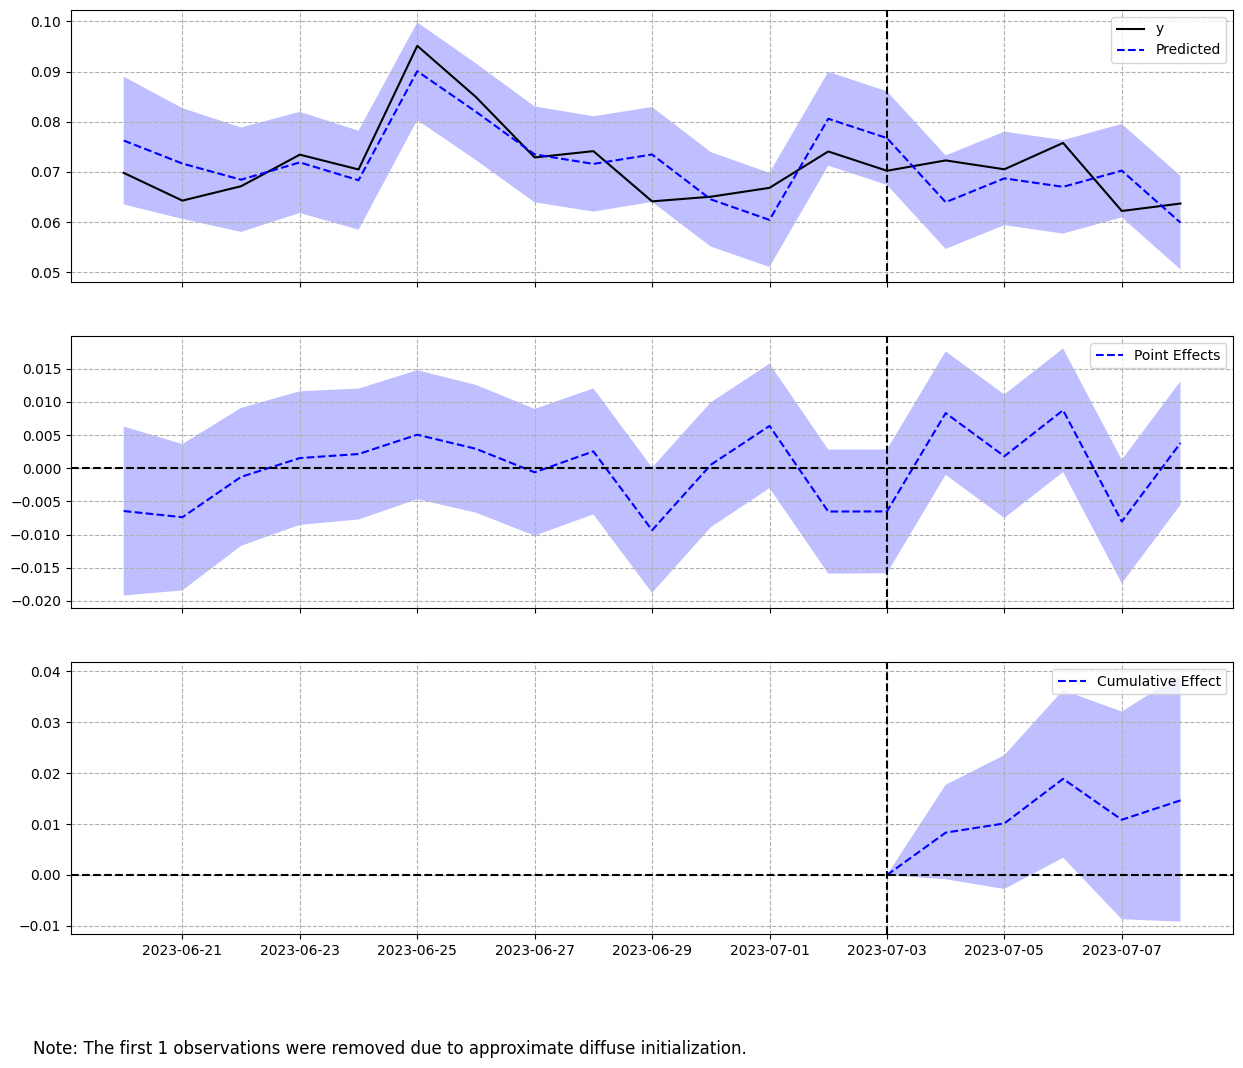

In [461]:
# Percentage of products PNA

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='perc_products_pna').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_perc_products_pna', 'Control_perc_products_pna']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_delivered_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_delivered_orders').reindex(columns=['Control'])
df_pivot['Control_avg_UIPO'] = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_perc_products_pna'
                                ,'Control_perc_products_pna'
                                ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model II: Average UIPO

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 8.47. In the absence of an
intervention, we would have expected an average response of 8.43.
The 95% interval of this counterfactual prediction is [8.17, 8.7].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.04 with a 95% interval of
[-0.23, 0.29]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 42.34.
Had the intervention not taken place, we would have expected
a sum of 42.14. The 95% interval of this prediction is [40.87, 43.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +0.48%. The 

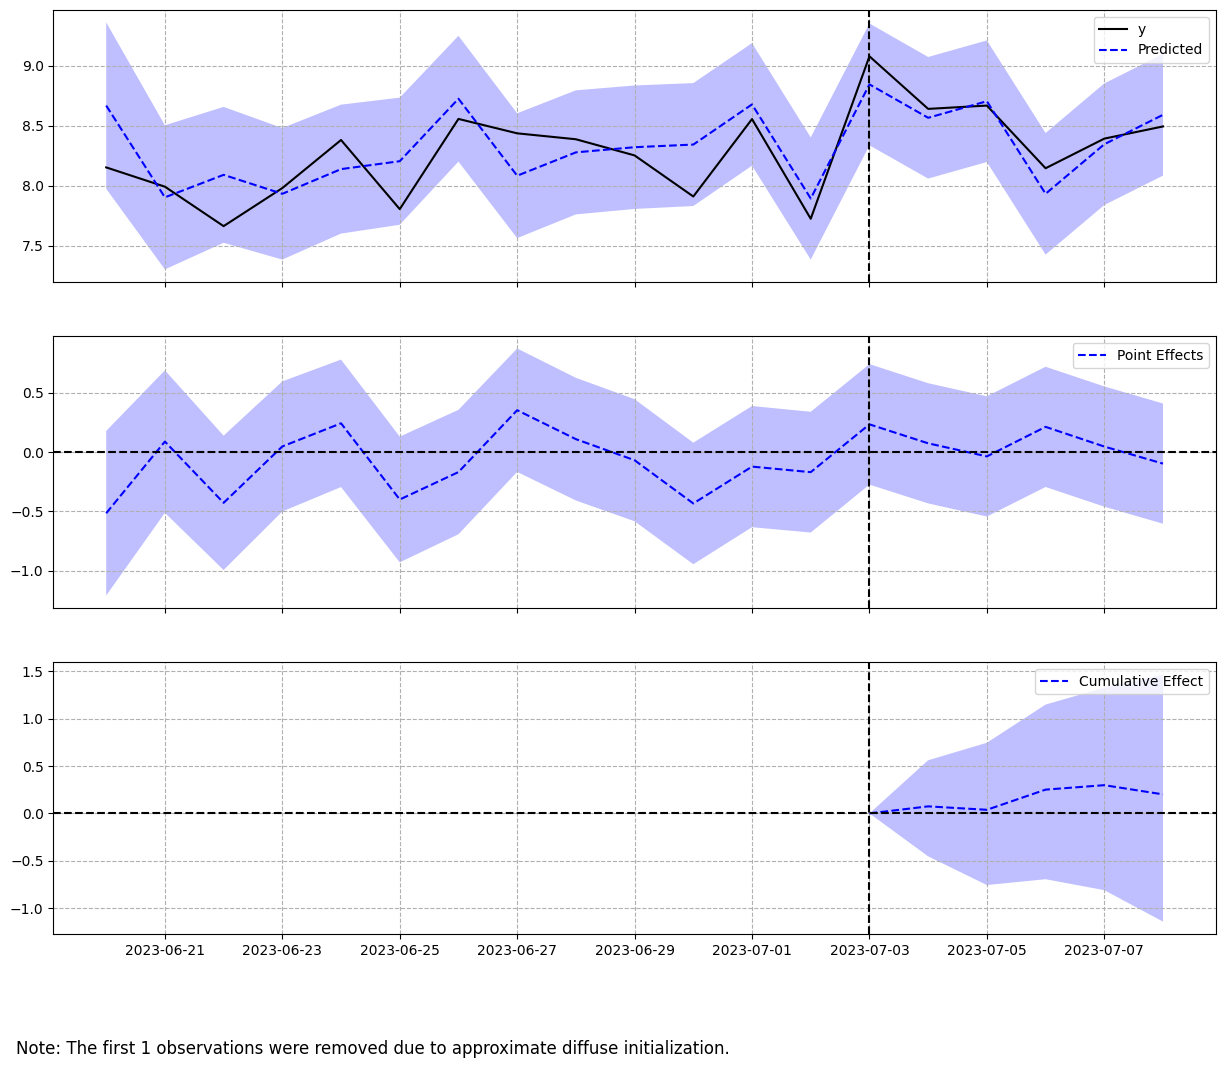

In [462]:
# Average UIPO

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_avg_UIPO', 'Control_avg_UIPO']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_avg_UIPO'
                            ,'Control_avg_UIPO'
                            ,'Control_number_of_orders'
                            ,'Control_total_quantity_placed']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model III: Number of Orders

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1046.0. In the absence of an
intervention, we would have expected an average response of 1123.52.
The 95% interval of this counterfactual prediction is [1034.39, 1215.85].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -77.52 with a 95% interval of
[-169.85, 11.61]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5230.0.
Had the intervention not taken place, we would have expected
a sum of 5617.58. The 95% interval of this prediction is [5171.96, 6079.26].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a d

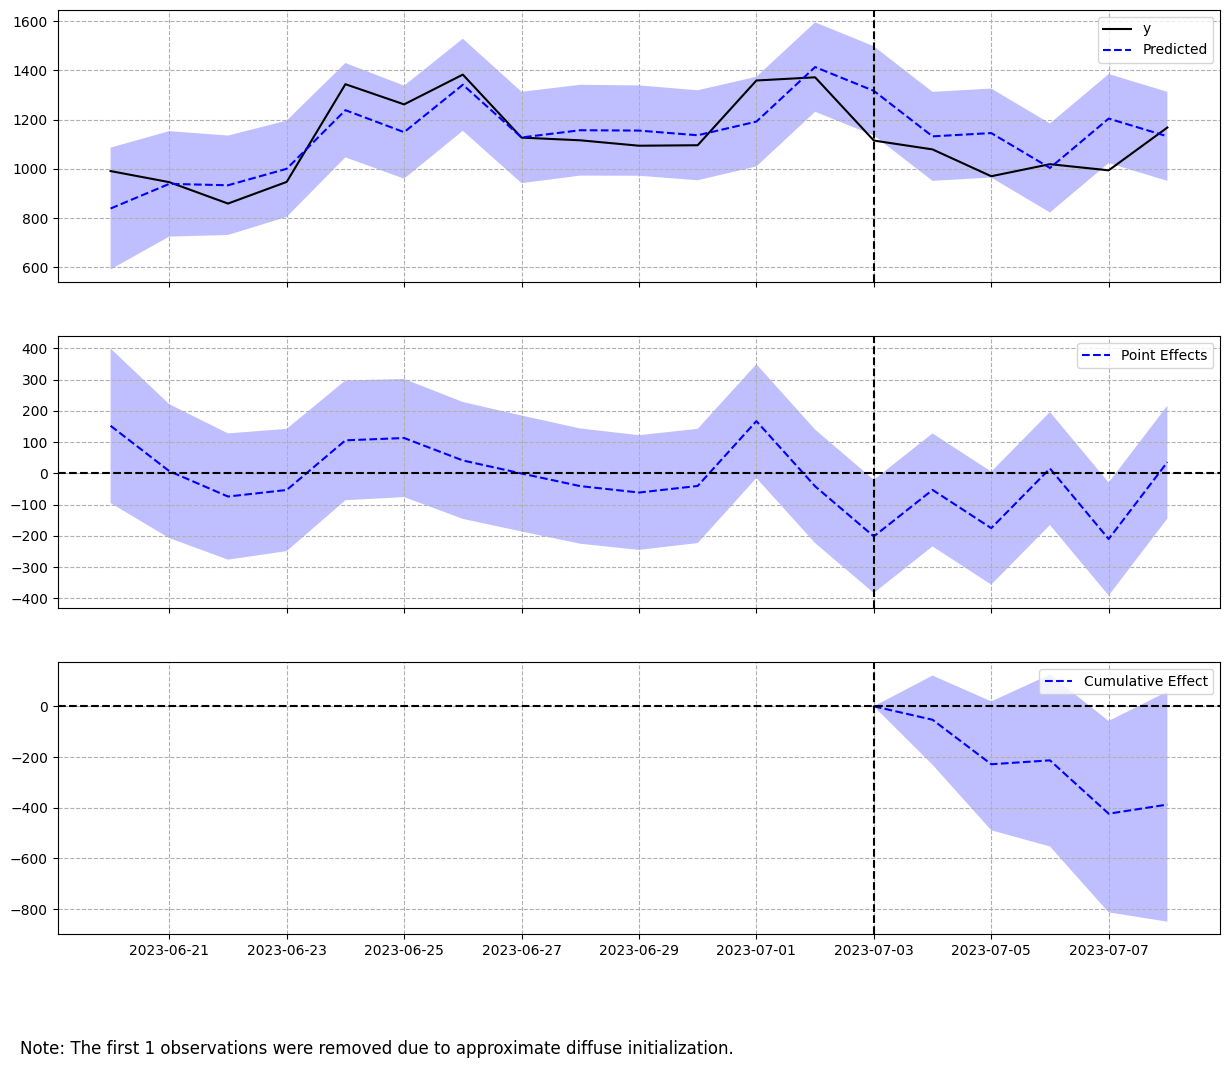

In [463]:
# Number of orders

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_number_of_orders', 'Control_number_of_orders']  # Rename the first columns
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_number_of_orders'
                            ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

## Analysis CARR_IT

In [464]:
# Params
group_name = 'CARR_IT'
file_csv_group_name = 'CARR_IT.csv'
start_pre = "2023-06-19"
end_pre = "2023-07-03"
start_post = "2023-07-04"
end_post = "2023-07-08"

Join with info of the d_inner, which is enriched data from queries

In [465]:
# Load groups info 
d_groups = rw.csv_read_file(file_csv_group_name)
# PNA
d_filtered = d_inner[d_inner['group_name'] == group_name] # Only keep the filtered group name
d_filtered_w_groups = pd.merge(d_filtered, d_groups, on='store_address_id') # Add the groups info
# Prod availability
d_filtered_prod_avail = d_inner_prod_avail[d_inner_prod_avail['group_name'] == group_name] # Only keep the filtered group name
d_filtered_prod_avail_w_groups = pd.merge(d_filtered_prod_avail, d_groups, on='store_address_id') # Add the groups info

# Report
print('There are {} distinct store_addresses for {} in d_inner'.format(d_filtered['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_groups'.format(d_filtered_w_groups['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses for {} in d_inner_prod_avail'.format(d_filtered_prod_avail['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_prod_avail_groups'.format(d_filtered_prod_avail_w_groups['store_address_id'].nunique(),group_name))


There are 313 distinct store_addresses for CARR_IT in d_inner
There are 313 distinct store_addresses fror CARR_IT in d_inner_groups
There are 387 distinct store_addresses for CARR_IT in d_inner_prod_avail
There are 321 distinct store_addresses fror CARR_IT in d_inner_prod_avail_groups


Prepare the df_synth_format for the synthetic control with all needed variables in groupby format

In [466]:
# Data period range
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

# Group by and compute the metrics for synth format
df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'
                                                        ,'number_of_placed_products'
                                                        ,'number_of_orders'
                                                        ,'number_of_delivered_orders'
                                                        ,'total_quantity_placed'
                                                        ,'products_value_placed'
                                                        ].sum().reset_index()

df_synth_format['perc_products_pna'] = df_synth_format['number_of_products_with_pna']/df_synth_format['number_of_placed_products']
df_synth_format['avg_UIPO'] = df_synth_format['number_of_placed_products']/df_synth_format['number_of_orders']
df_synth_format.head()

C:\Users\Jordi Cremades\AppData\Local\Temp\ipykernel_12548\280939351.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'


,date,Group,number_of_products_with_pna,number_of_placed_products,number_of_orders,number_of_delivered_orders,total_quantity_placed,products_value_placed,perc_products_pna,avg_UIPO
0,2023-06-19,Control,311,3351,423,407,4575,11559.73,0.092808,7.921986
1,2023-06-19,Treat,866,9563,1291,1236,13490,34714.49,0.090557,7.407436
2,2023-06-20,Control,224,2460,329,324,3415,8651.15,0.091057,7.477204
3,2023-06-20,Treat,651,7869,1077,1037,11041,28169.77,0.082730,7.306407
4,2023-06-21,Control,224,2753,359,351,3828,9634.61,0.081366,7.668524


Eye check of the df_synth_fromat

In [467]:
eye_check_columns = [
    'number_of_products_with_pna'
    ,'number_of_placed_products'
    ,'number_of_orders'
    ,'number_of_delivered_orders'
    ,'total_quantity_placed'
    ,'products_value_placed'
    ,'perc_products_pna'
    ,'avg_UIPO'
] 
df_eye_check = df_synth_format.pivot_table(index='date', columns='Group', values=eye_check_columns)
df_eye_check

avg_UIPO           number_of_delivered_orders        \
Group        Control     Treat                    Control Treat   
date                                                              
2023-06-19  7.921986  7.407436                        407  1236   
2023-06-20  7.477204  7.306407                        324  1037   
2023-06-21  7.668524  7.201835                        351  1032   
2023-06-22  7.214706  7.457391                        327  1104   
2023-06-23  7.537764  7.342358                        320  1090   
2023-06-24  7.598916  7.681401                        352  1143   
2023-06-25  7.785354  7.726120                        384  1137   
2023-06-26  7.601604  7.516295                        353  1100   
2023-06-27  7.051205  7.380020                        329   973   
2023-06-28  7.479245  7.340378                        251   858   
2023-06-29  7.038298  7.372483                        227   842   
2023-06-30  7.438017  7.378310                        226   743   
2023-07-01  7.650641  7.943807                        297   837   
2023-07-02  7.667883  7.584137                        257   890   
2023-07-03  8.516014  8.587104                        261   845   
2023-07-04  7.515152  7.745392                        254   826   
2023-07-05  6.777049  7.622047                        296   870   
2023-07-06  7.508333  7.672576                        231   917   
2023-07-07  7.809524  7.772300                        227   828   
2023-07-08  8.245552  7.837209                        276   999   

           number_of_orders       number_of_placed_products        \
Group               Control Treat                   Control Treat   
date                                                                
2023-06-19              423  1291                      3351  9563   
2023-06-20              329  1077                      2460  7869   
2023-06-21              359  1090                      2753  7850   
2023-06-22              340  1150                      2453  8576   
2023-06-23              331  1145                      2495  8407   
2023-06-24              369  1199                      2804  9210   
2023-06-25              396  1183                      3083  9140   
2023-06-26              374  1166                      2843  8764   
2023-06-27              332  1021                      2341  7535   
2023-06-28              265   899                      1982  6599   
2023-06-29              235   894                      1654  6591   
2023-06-30              242   793                      1800  5851   
2023-07-01              312   872                      2387  6927   
2023-07-02              274   933                      2101  7076   
2023-07-03              281   884                      2393  7591   
2023-07-04              264   868                      1984  6723   
2023-07-05              305   889                      2067  6776   
2023-07-06              240   959                      1802  7358   
2023-07-07              231   852                      1804  6622   
2023-07-08              281  1032                      2317  8088   

           number_of_products_with_pna       perc_products_pna            \
Group                          Control Treat           Control     Treat   
date                                                                       
2023-06-19                         311   866          0.092808  0.090557   
2023-06-20                         224   651          0.091057  0.082730   
2023-06-21                         224   559          0.081366  0.071210   
2023-06-22                         189   643          0.077049  0.074977   
2023-06-23                         174   659          0.069739  0.078387   
2023-06-24                         232   646          0.082739  0.070141   
2023-06-25                         358   892          0.116121  0.097593   
2023-06-26                         260   906          0.091453  0.103377   
2023-06-27                         224   609  

Eye check of the df_eye_check_ratio

In [468]:
#For ratio_perc we see the perc of Control over the total Control + Treat.
#For ratio subract, we only subtract Control to Treat. This is useful
#for percentages, averages...

# Ratio perc: CONTROL/CONTROL+TREAT
# Ratio subtract: CONTROL-TREAT

# Params
ratio_perc = ['number_of_delivered_orders', 'number_of_orders', 'number_of_placed_products', 'number_of_products_with_pna', 'products_value_placed', 'total_quantity_placed']
ratio_subract = ['avg_UIPO', 'perc_products_pna']

# Iterate over the columns and calculate the ratio or perform subtraction based on the lists
for column in df_eye_check.columns:
    if column[1] == 'Control':
        if column[0] in ratio_perc:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] / (df_eye_check[column] + df_eye_check[column[0], 'Treat'])
        elif column[0] in ratio_subract:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] - df_eye_check[column[0], 'Treat']

# Print the updated DataFrame
df_eye_check_ratio = df_eye_check.xs('ratio', axis=1, level=1)
df_eye_check_ratio

,avg_UIPO,number_of_delivered_orders,number_of_orders,number_of_placed_products,number_of_products_with_pna,perc_products_pna,products_value_placed,total_quantity_placed
date,,,,,,,,
2023-06-19,0.514550,0.247718,0.246791,0.259486,0.264231,0.002251,0.249809,0.253252
2023-06-20,0.170797,0.238060,0.233997,0.238164,0.256000,0.008327,0.234952,0.236234
2023-06-21,0.466689,0.253796,0.247757,0.259643,0.286079,0.010156,0.254914,0.255285
2023-06-22,-0.242685,0.228512,0.228188,0.222414,0.227163,0.002072,0.223903,0.222653
2023-06-23,0.195406,0.226950,0.224255,0.228857,0.208884,-0.008648,0.220434,0.224422
2023-06-24,-0.082485,0.235452,0.235332,0.233394,0.264237,0.012598,0.233516,0.238479
2023-06-25,0.059234,0.252465,0.250792,0.252229,0.286400,0.018528,0.255192,0.252837
2023-06-26,0.085309,0.242946,0.242857,0.244938,0.222985,-0.011925,0.238717,0.241097
2023-06-27,-0.328815,0.252688,0.245381,0.237039,0.268908,0.014863,0.246022,0.233431


Model I: Percentage of products PNA

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.08. By contrast, in the absence of an
intervention, we would have expected an average response of 0.07.
The 95% interval of this counterfactual prediction is [0.06, 0.08].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 0.39.
By contrast, had the intervention not taken place, we would have expected
a sum of 0.35. The 95% interval of this prediction is [0.32, 0.39].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an inc

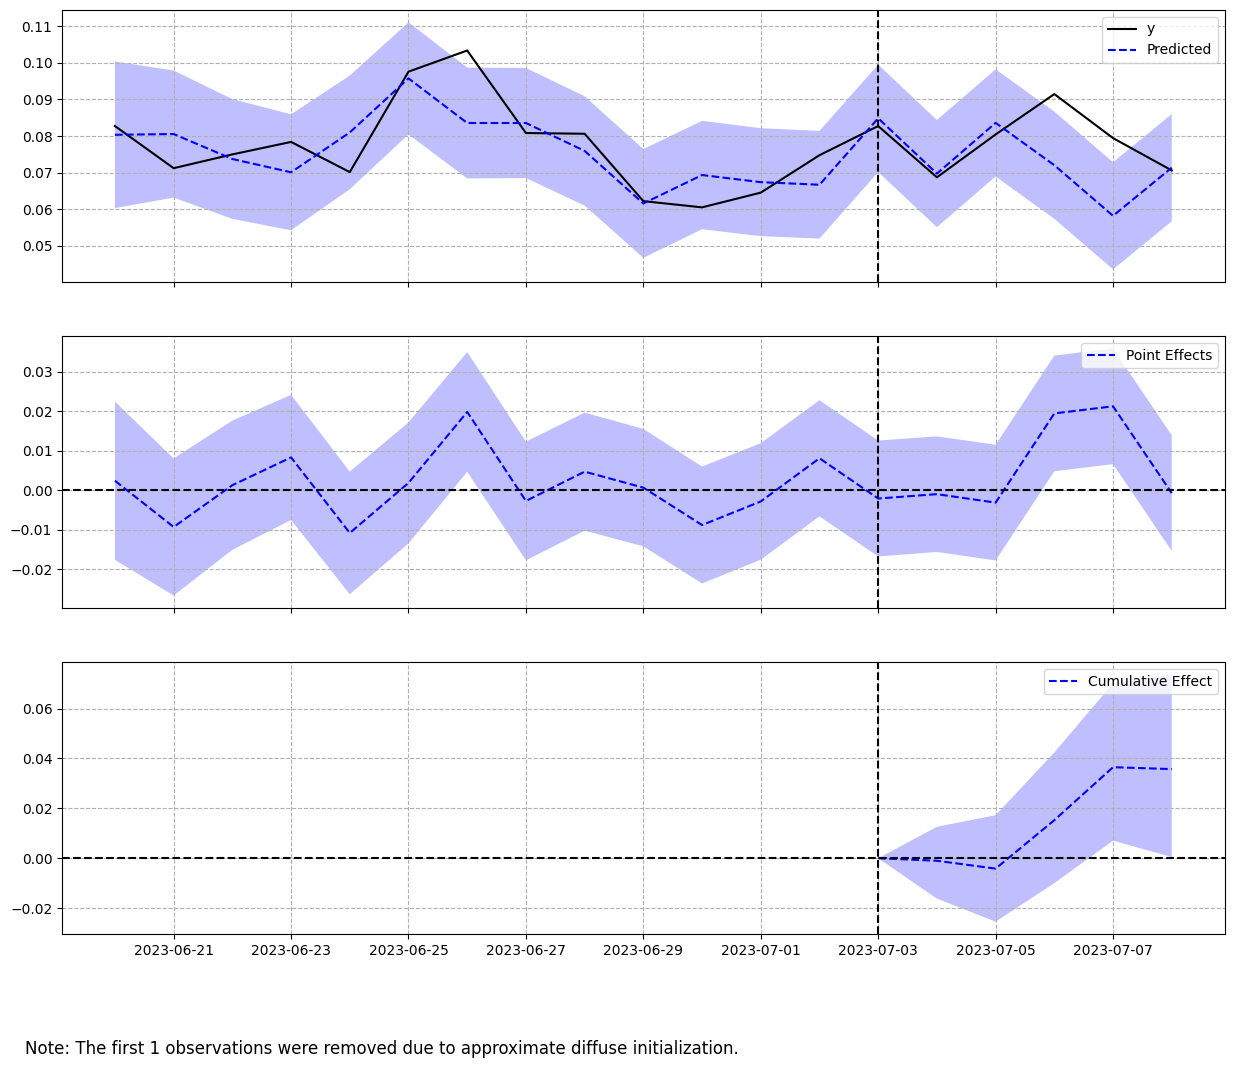

In [469]:
# Percentage of products PNA

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='perc_products_pna').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_perc_products_pna', 'Control_perc_products_pna']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_delivered_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_delivered_orders').reindex(columns=['Control'])
df_pivot['Control_avg_UIPO'] = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_perc_products_pna'
                                ,'Control_perc_products_pna'
                                ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model II: Average UIPO

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 7.73. In the absence of an
intervention, we would have expected an average response of 7.65.
The 95% interval of this counterfactual prediction is [7.41, 7.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.08 with a 95% interval of
[-0.15, 0.32]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 38.65.
Had the intervention not taken place, we would have expected
a sum of 38.27. The 95% interval of this prediction is [37.07, 39.39].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +1.0%. The 

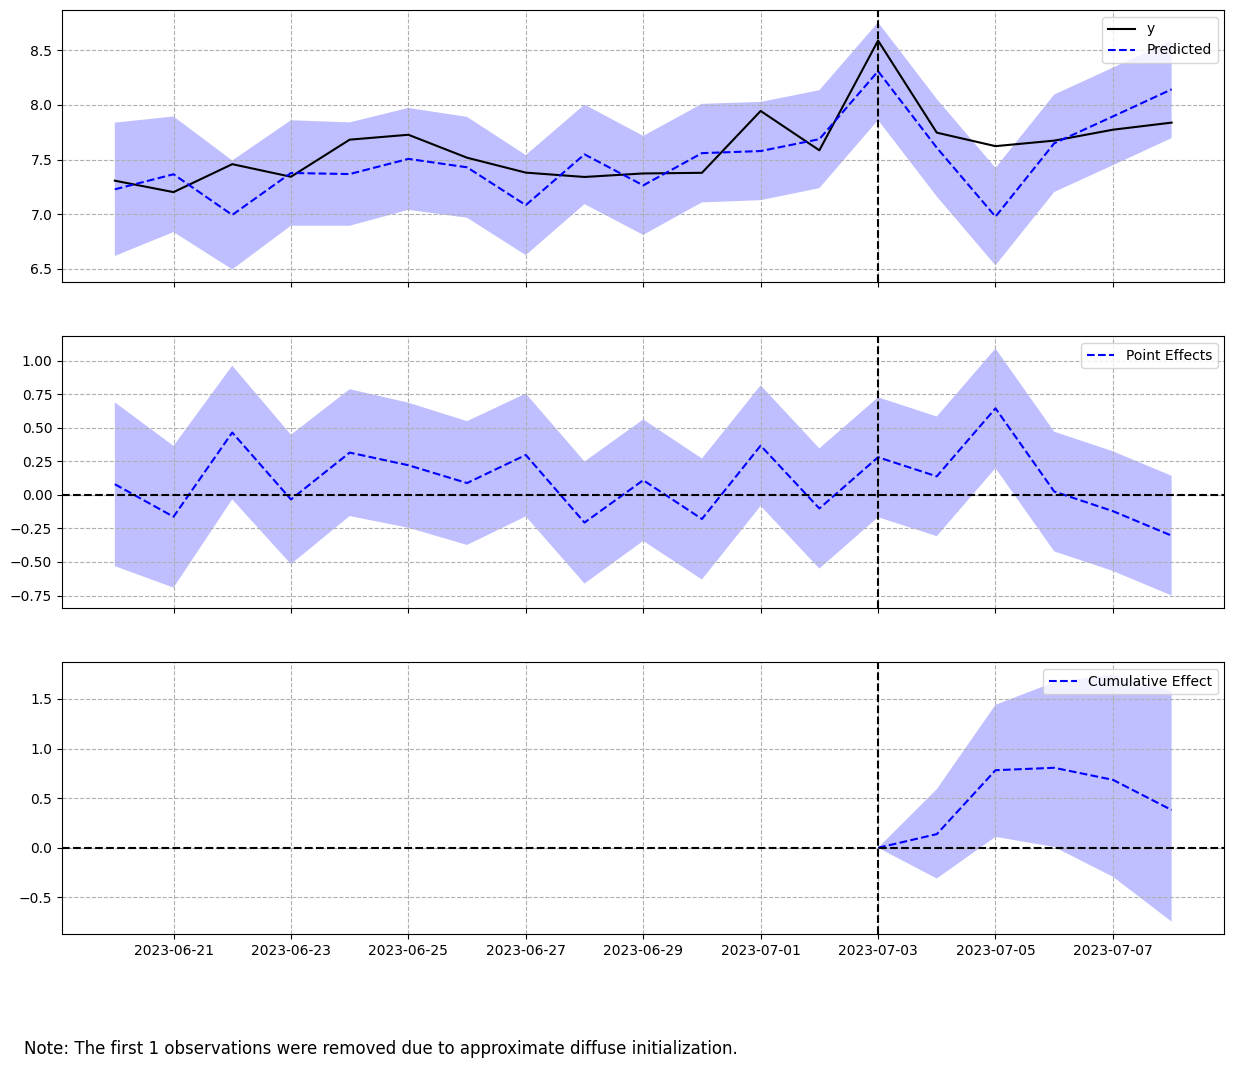

In [470]:
# Average UIPO

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_avg_UIPO', 'Control_avg_UIPO']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_avg_UIPO'
                            ,'Control_avg_UIPO'
                            ,'Control_number_of_orders'
                            ,'Control_total_quantity_placed']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model III: Number of Orders

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 920.0. In the absence of an
intervention, we would have expected an average response of 890.78.
The 95% interval of this counterfactual prediction is [832.42, 950.86].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 29.22 with a 95% interval of
[-30.86, 87.58]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 4600.0.
Had the intervention not taken place, we would have expected
a sum of 4453.89. The 95% interval of this prediction is [4162.11, 4754.3].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increas

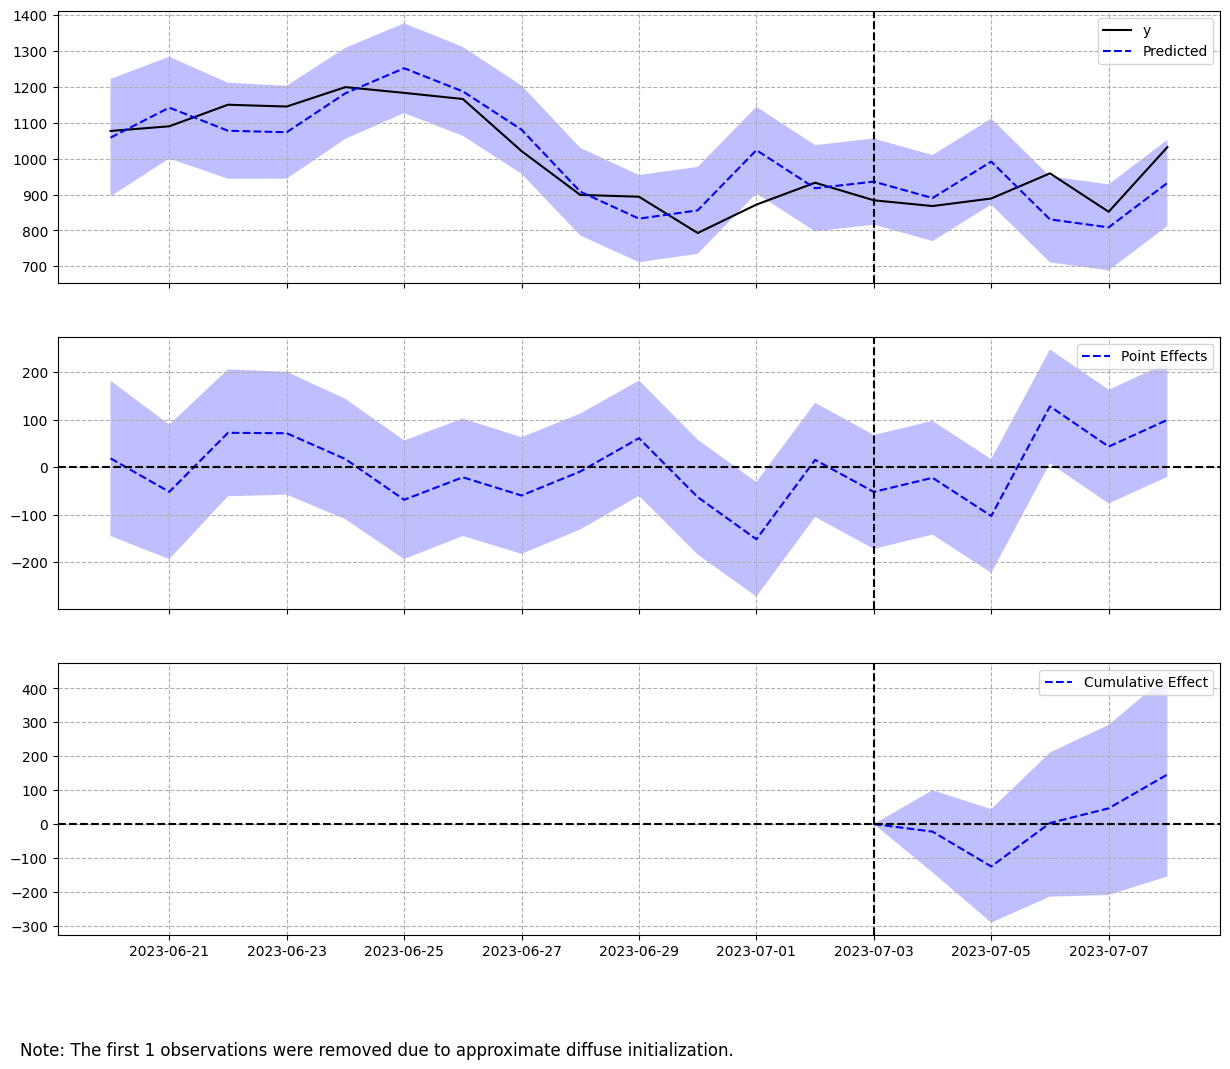

In [471]:
# Number of orders

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_number_of_orders', 'Control_number_of_orders']  # Rename the first columns
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_number_of_orders'
                            ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

## Analysis CONT_PT

In [472]:
# Params
group_name = 'CONT_PT'
file_csv_group_name = 'CONT_PT.csv'
start_pre = "2023-06-19"
end_pre = "2023-07-03"
start_post = "2023-07-04"
end_post = "2023-07-08"

Join with info of the d_inner, which is enriched data from queries

In [473]:
# Load groups info 
d_groups = rw.csv_read_file(file_csv_group_name)
# PNA
d_filtered = d_inner[d_inner['group_name'] == group_name] # Only keep the filtered group name
d_filtered_w_groups = pd.merge(d_filtered, d_groups, on='store_address_id') # Add the groups info
# Prod availability
d_filtered_prod_avail = d_inner_prod_avail[d_inner_prod_avail['group_name'] == group_name] # Only keep the filtered group name
d_filtered_prod_avail_w_groups = pd.merge(d_filtered_prod_avail, d_groups, on='store_address_id') # Add the groups info

# Report
print('There are {} distinct store_addresses for {} in d_inner'.format(d_filtered['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_groups'.format(d_filtered_w_groups['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses for {} in d_inner_prod_avail'.format(d_filtered_prod_avail['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_prod_avail_groups'.format(d_filtered_prod_avail_w_groups['store_address_id'].nunique(),group_name))


There are 179 distinct store_addresses for CONT_PT in d_inner
There are 179 distinct store_addresses fror CONT_PT in d_inner_groups
There are 179 distinct store_addresses for CONT_PT in d_inner_prod_avail
There are 179 distinct store_addresses fror CONT_PT in d_inner_prod_avail_groups


Prepare the df_synth_format for the synthetic control with all needed variables in groupby format

In [474]:
# Data period range
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

# Group by and compute the metrics for synth format
df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'
                                                        ,'number_of_placed_products'
                                                        ,'number_of_orders'
                                                        ,'number_of_delivered_orders'
                                                        ,'total_quantity_placed'
                                                        ,'products_value_placed'
                                                        ].sum().reset_index()

df_synth_format['perc_products_pna'] = df_synth_format['number_of_products_with_pna']/df_synth_format['number_of_placed_products']
df_synth_format['avg_UIPO'] = df_synth_format['number_of_placed_products']/df_synth_format['number_of_orders']
df_synth_format.head()

C:\Users\Jordi Cremades\AppData\Local\Temp\ipykernel_12548\280939351.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'


,date,Group,number_of_products_with_pna,number_of_placed_products,number_of_orders,number_of_delivered_orders,total_quantity_placed,products_value_placed,perc_products_pna,avg_UIPO
0,2023-06-19,Control,269,3088,375,363,3988,8525.24,0.087111,8.234667
1,2023-06-19,Treat,814,9112,1072,1006,11459,24816.97,0.089333,8.500000
2,2023-06-20,Control,177,2178,290,279,2686,6179.02,0.081267,7.510345
3,2023-06-20,Treat,642,7672,958,915,9753,21068.89,0.083681,8.008351
4,2023-06-21,Control,206,2298,288,275,2913,6501.71,0.089643,7.979167


Eye check of the df_synth_fromat

In [475]:
eye_check_columns = [
    'number_of_products_with_pna'
    ,'number_of_placed_products'
    ,'number_of_orders'
    ,'number_of_delivered_orders'
    ,'total_quantity_placed'
    ,'products_value_placed'
    ,'perc_products_pna'
    ,'avg_UIPO'
] 
df_eye_check = df_synth_format.pivot_table(index='date', columns='Group', values=eye_check_columns)
df_eye_check

avg_UIPO           number_of_delivered_orders        \
Group        Control     Treat                    Control Treat   
date                                                              
2023-06-19  8.234667  8.500000                        363  1006   
2023-06-20  7.510345  8.008351                        279   915   
2023-06-21  7.979167  8.105416                        275   976   
2023-06-22  7.943750  8.061876                        305   954   
2023-06-23  6.756184  6.788100                        267   889   
2023-06-24  6.990937  7.267299                        321   994   
2023-06-25  7.885321  7.595122                        416  1348   
2023-06-26  7.375415  7.268817                        284   883   
2023-06-27  7.375415  7.821086                        279   896   
2023-06-28  8.554286  7.903162                        332   965   
2023-06-29  7.943787  8.048193                        317   939   
2023-06-30  7.775910  8.076617                        344   929   
2023-07-01  8.396437  8.547002                        426  1270   
2023-07-02  8.124717  8.394622                        410  1288   
2023-07-03  8.323782  8.090188                        321   948   
2023-07-04  8.433898  7.922737                        274   854   
2023-07-05  7.808081  8.084817                        283   904   
2023-07-06  7.858859  7.889145                        309   807   
2023-07-07  7.473333  7.737955                        284   824   
2023-07-08  8.184971  8.355472                        330  1019   

           number_of_orders       number_of_placed_products         \
Group               Control Treat                   Control  Treat   
date                                                                 
2023-06-19              375  1072                      3088   9112   
2023-06-20              290   958                      2178   7672   
2023-06-21              288  1034                      2298   8381   
2023-06-22              320  1002                      2542   8078   
2023-06-23              283   958                      1912   6503   
2023-06-24              331  1055                      2314   7667   
2023-06-25              436  1435                      3438  10899   
2023-06-26              301   930                      2220   6760   
2023-06-27              301   939                      2220   7344   
2023-06-28              350  1012                      2994   7998   
2023-06-29              338   996                      2685   8016   
2023-06-30              357  1005                      2776   8117   
2023-07-01              449  1351                      3770  11547   
2023-07-02              441  1376                      3583  11551   
2023-07-03              349  1009                      2905   8163   
2023-07-04              295   906                      2488   7178   
2023-07-05              297   955                      2319   7721   
2023-07-06              333   866                      2617   6832   
2023-07-07              300   851                      2242   6585   
2023-07-08              346  1069                      2832   8932   

           number_of_products_with_pna       perc_products_pna            \
Group                          Control Treat           Control     Treat   
date                                                                       
2023-06-19                         269   814          0.087111  0.089333   
2023-06-20                         177   642          0.081267  0.083681   
2023-06-21                         206   810          0.089643  0.096647   
2023-06-22                         222   685          0.087333  0.084798   
2023-06-23                         180   568          0.094142  0.087344   
2023-06-24                         227   697          0.098099  0.090909   
2023-06-25                         328   912          0.095404  0.083677   
2023-06-26                         164   624          0.073874  0.092308   
2023-06-27             

Eye check of the df_eye_check_ratio

In [476]:
#For ratio_perc we see the perc of Control over the total Control + Treat.
#For ratio subract, we only subtract Control to Treat. This is useful
#for percentages, averages...

# Ratio perc: CONTROL/CONTROL+TREAT
# Ratio subtract: CONTROL-TREAT

# Params
ratio_perc = ['number_of_delivered_orders', 'number_of_orders', 'number_of_placed_products', 'number_of_products_with_pna', 'products_value_placed', 'total_quantity_placed']
ratio_subract = ['avg_UIPO', 'perc_products_pna']

# Iterate over the columns and calculate the ratio or perform subtraction based on the lists
for column in df_eye_check.columns:
    if column[1] == 'Control':
        if column[0] in ratio_perc:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] / (df_eye_check[column] + df_eye_check[column[0], 'Treat'])
        elif column[0] in ratio_subract:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] - df_eye_check[column[0], 'Treat']

# Print the updated DataFrame
df_eye_check_ratio = df_eye_check.xs('ratio', axis=1, level=1)
df_eye_check_ratio

,avg_UIPO,number_of_delivered_orders,number_of_orders,number_of_placed_products,number_of_products_with_pna,perc_products_pna,products_value_placed,total_quantity_placed
date,,,,,,,,
2023-06-19,-0.265333,0.265157,0.259157,0.253115,0.248384,-0.002221,0.255689,0.258173
2023-06-20,-0.498006,0.233668,0.232372,0.221117,0.216117,-0.002414,0.226770,0.215934
2023-06-21,-0.126249,0.219824,0.217852,0.215189,0.202756,-0.007004,0.213813,0.212240
2023-06-22,-0.118126,0.242256,0.242057,0.239360,0.244763,0.002535,0.243640,0.243062
2023-06-23,-0.031916,0.230969,0.228042,0.227213,0.240642,0.006798,0.223082,0.233320
2023-06-24,-0.276362,0.244106,0.238817,0.231840,0.245671,0.007189,0.233309,0.237894
2023-06-25,0.290199,0.235828,0.233030,0.239799,0.264516,0.011727,0.242468,0.238451
2023-06-26,0.106598,0.243359,0.244517,0.247216,0.208122,-0.018434,0.239970,0.236092
2023-06-27,-0.445671,0.237447,0.242742,0.232120,0.214988,-0.008181,0.230527,0.232076


Model I: Percentage of products PNA

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.09. In the absence of an
intervention, we would have expected an average response of 0.09.
The 95% interval of this counterfactual prediction is [0.08, 0.1].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -0.0 with a 95% interval of
[-0.01, 0.0]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 0.43.
Had the intervention not taken place, we would have expected
a sum of 0.44. The 95% interval of this prediction is [0.4, 0.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -2.78%. The 95%
int

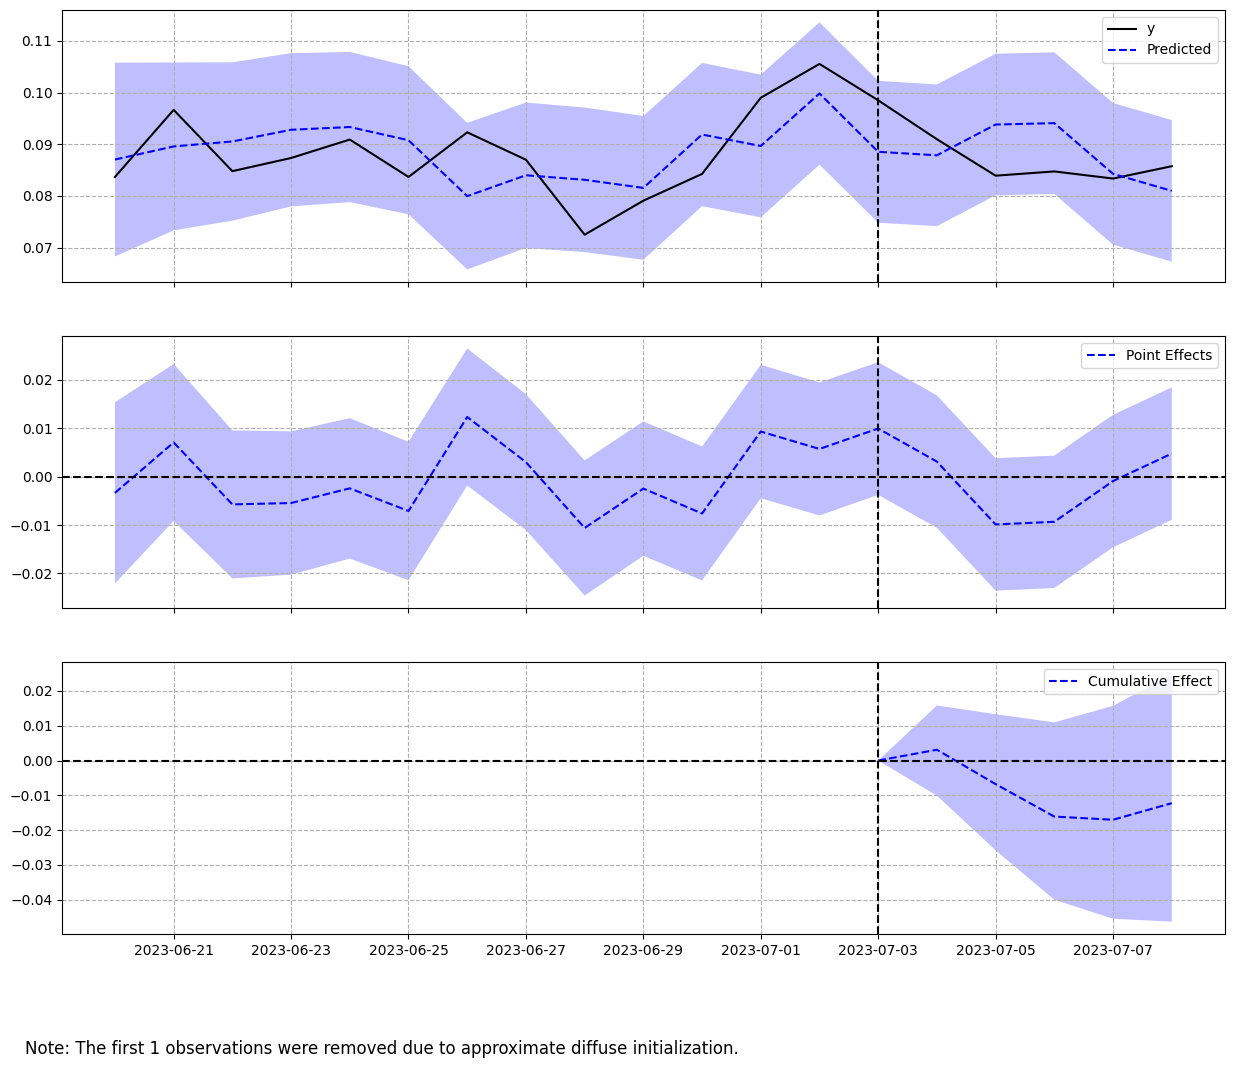

In [477]:
# Percentage of products PNA

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='perc_products_pna').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_perc_products_pna', 'Control_perc_products_pna']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_delivered_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_delivered_orders').reindex(columns=['Control'])
df_pivot['Control_avg_UIPO'] = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_perc_products_pna'
                                ,'Control_perc_products_pna'
                                ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model II: Average UIPO

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 8.0. In the absence of an
intervention, we would have expected an average response of 7.99.
The 95% interval of this counterfactual prediction is [7.71, 8.25].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[-0.25, 0.29]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 39.99.
Had the intervention not taken place, we would have expected
a sum of 39.94. The 95% interval of this prediction is [38.55, 41.25].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +0.14%. The 

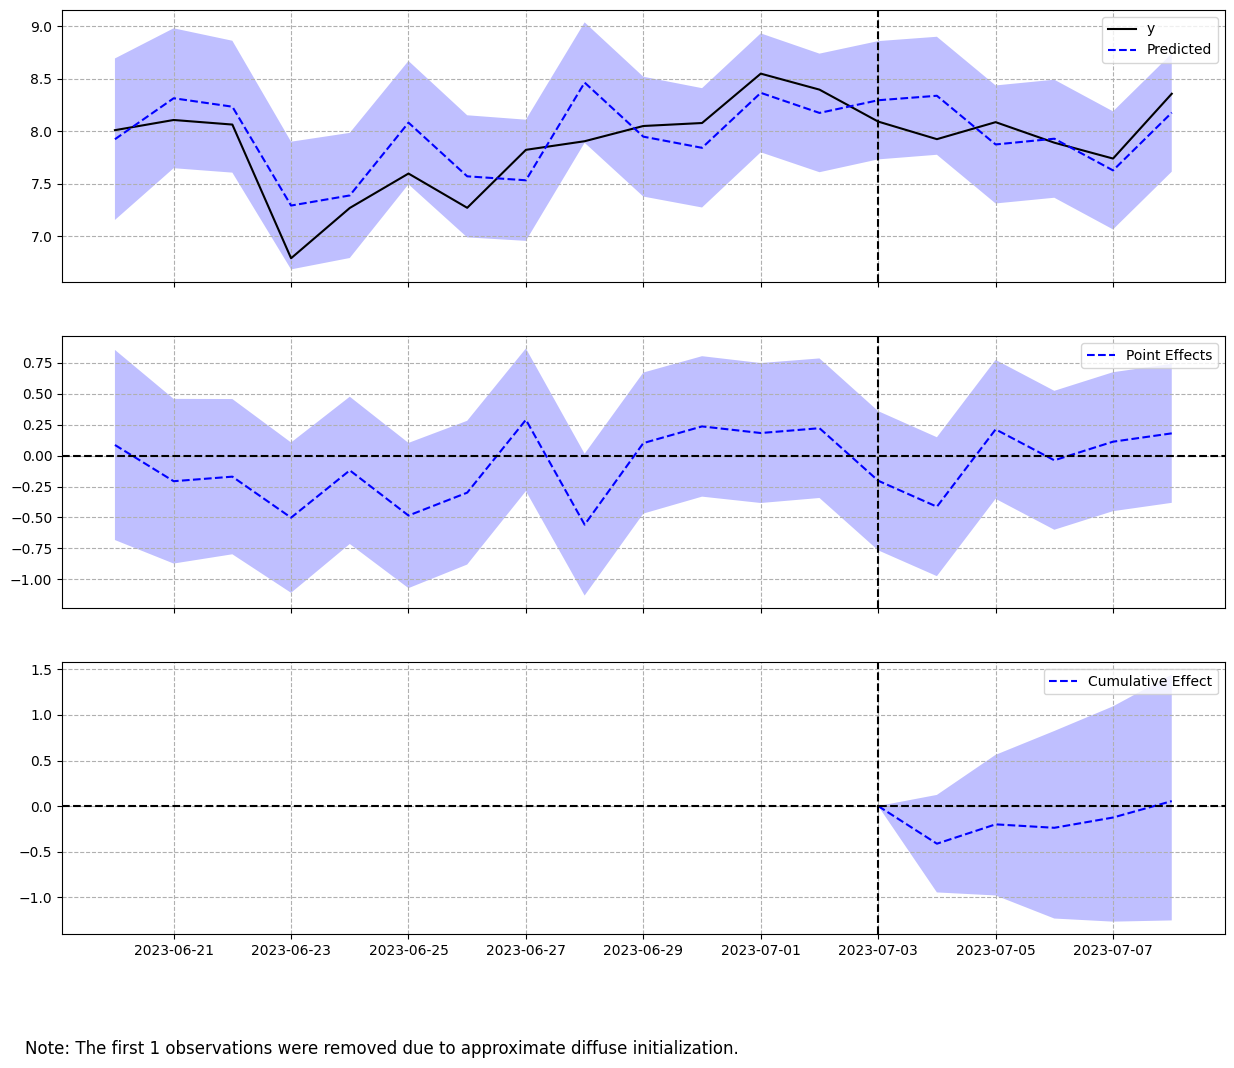

In [478]:
# Average UIPO

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_avg_UIPO', 'Control_avg_UIPO']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_avg_UIPO'
                            ,'Control_avg_UIPO'
                            ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model III: Number of Orders

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 929.4. In the absence of an
intervention, we would have expected an average response of 984.89.
The 95% interval of this counterfactual prediction is [915.04, 1052.43].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -55.49 with a 95% interval of
[-123.03, 14.36]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 4647.0.
Had the intervention not taken place, we would have expected
a sum of 4924.45. The 95% interval of this prediction is [4575.21, 5262.15].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decr

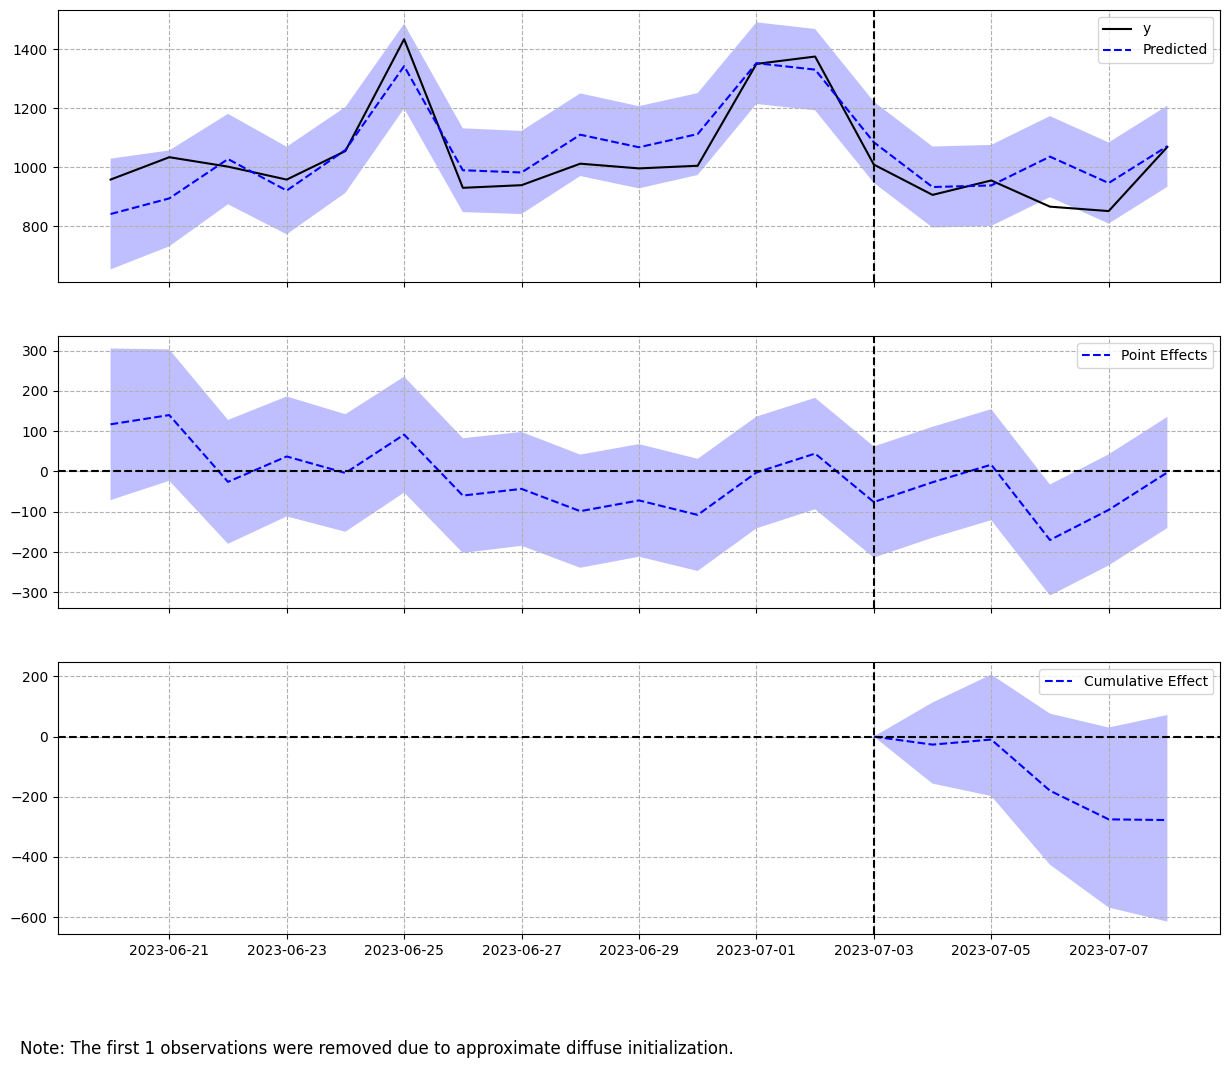

In [479]:
# Number of orders

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_number_of_orders', 'Control_number_of_orders']  # Rename the first columns
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_number_of_orders'
                            ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

## Analysis NIKO_GE

In [480]:
# Params
group_name = 'NIKO_GE'
file_csv_group_name = 'NIKO_GE.csv'
start_pre = "2023-06-19"
end_pre = "2023-07-03"
start_post = "2023-07-04"
end_post = "2023-07-08"

Join with info of the d_inner, which is enriched data from queries

In [481]:
# Load groups info 
d_groups = rw.csv_read_file(file_csv_group_name)
# PNA
d_filtered = d_inner[d_inner['group_name'] == group_name] # Only keep the filtered group name
d_filtered_w_groups = pd.merge(d_filtered, d_groups, on='store_address_id') # Add the groups info
# Prod availability
d_filtered_prod_avail = d_inner_prod_avail[d_inner_prod_avail['group_name'] == group_name] # Only keep the filtered group name
d_filtered_prod_avail_w_groups = pd.merge(d_filtered_prod_avail, d_groups, on='store_address_id') # Add the groups info

# Report
print('There are {} distinct store_addresses for {} in d_inner'.format(d_filtered['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_groups'.format(d_filtered_w_groups['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses for {} in d_inner_prod_avail'.format(d_filtered_prod_avail['store_address_id'].nunique(),group_name))
print('There are {} distinct store_addresses fror {} in d_inner_prod_avail_groups'.format(d_filtered_prod_avail_w_groups['store_address_id'].nunique(),group_name))


There are 40 distinct store_addresses for NIKO_GE in d_inner
There are 40 distinct store_addresses fror NIKO_GE in d_inner_groups
There are 46 distinct store_addresses for NIKO_GE in d_inner_prod_avail
There are 41 distinct store_addresses fror NIKO_GE in d_inner_prod_avail_groups


Prepare the df_synth_format for the synthetic control with all needed variables in groupby format

In [482]:
# Data period range
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

# Group by and compute the metrics for synth format
df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'
                                                        ,'number_of_placed_products'
                                                        ,'number_of_orders'
                                                        ,'number_of_delivered_orders'
                                                        ,'total_quantity_placed'
                                                        ,'products_value_placed'
                                                        ].sum().reset_index()

df_synth_format['perc_products_pna'] = df_synth_format['number_of_products_with_pna']/df_synth_format['number_of_placed_products']
df_synth_format['avg_UIPO'] = df_synth_format['number_of_placed_products']/df_synth_format['number_of_orders']
df_synth_format.head()

C:\Users\Jordi Cremades\AppData\Local\Temp\ipykernel_12548\280939351.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_synth_format = d_filtered_w_groups.groupby(['date', 'Group'])['number_of_products_with_pna'


,date,Group,number_of_products_with_pna,number_of_placed_products,number_of_orders,number_of_delivered_orders,total_quantity_placed,products_value_placed,perc_products_pna,avg_UIPO
0,2023-06-19,Control,18,311,54,50,525,731.459256,0.057878,5.759259
1,2023-06-19,Treat,100,2287,392,372,3709,5640.062428,0.043725,5.834184
2,2023-06-20,Control,12,216,44,41,333,540.818129,0.055556,4.909091
3,2023-06-20,Treat,104,2911,489,459,4609,6677.144169,0.035727,5.952965
4,2023-06-21,Control,6,189,35,34,317,360.419837,0.031746,5.400000


Eye check of the df_synth_fromat

In [483]:
eye_check_columns = [
    'number_of_products_with_pna'
    ,'number_of_placed_products'
    ,'number_of_orders'
    ,'number_of_delivered_orders'
    ,'total_quantity_placed'
    ,'products_value_placed'
    ,'perc_products_pna'
    ,'avg_UIPO'
] 
df_eye_check = df_synth_format.pivot_table(index='date', columns='Group', values=eye_check_columns)
df_eye_check

avg_UIPO           number_of_delivered_orders        \
Group        Control     Treat                    Control Treat   
date                                                              
2023-06-19  5.759259  5.834184                         50   372   
2023-06-20  4.909091  5.952965                         41   459   
2023-06-21  5.400000  5.642544                         34   431   
2023-06-22  6.428571  6.343750                         33   377   
2023-06-23  6.250000  5.911051                         35   357   
2023-06-24  5.621622  6.058455                         35   454   
2023-06-25  6.023810  6.104822                         38   447   
2023-06-26  5.354839  6.063107                         28   394   
2023-06-27  6.062500  6.125858                         32   413   
2023-06-28  5.392857  6.171111                         28   417   
2023-06-29  6.000000  6.280872                         35   384   
2023-06-30  5.611111  5.884696                         18   450   
2023-07-01  6.944444  5.819222                         36   422   
2023-07-02  5.214286  5.847981                         28   389   
2023-07-03  4.926829  5.919308                         39   330   
2023-07-04  7.312500  6.131965                         14   318   
2023-07-05  6.714286  5.942408                         14   360   
2023-07-06  7.269231  6.033742                         26   301   
2023-07-07  5.575758  5.750000                         31   339   
2023-07-08  7.526316  5.656338                         37   343   

           number_of_orders       number_of_placed_products        \
Group               Control Treat                   Control Treat   
date                                                                
2023-06-19               54   392                       311  2287   
2023-06-20               44   489                       216  2911   
2023-06-21               35   456                       189  2573   
2023-06-22               35   416                       225  2639   
2023-06-23               36   371                       225  2193   
2023-06-24               37   479                       208  2902   
2023-06-25               42   477                       253  2912   
2023-06-26               31   412                       166  2498   
2023-06-27               32   437                       194  2677   
2023-06-28               28   450                       151  2777   
2023-06-29               37   413                       222  2594   
2023-06-30               18   477                       101  2807   
2023-07-01               36   437                       250  2543   
2023-07-02               28   421                       146  2462   
2023-07-03               41   347                       202  2054   
2023-07-04               16   341                       117  2091   
2023-07-05               14   382                        94  2270   
2023-07-06               26   326                       189  1967   
2023-07-07               33   356                       184  2047   
2023-07-08               38   355                       286  2008   

           number_of_products_with_pna       perc_products_pna            \
Group                          Control Treat           Control     Treat   
date                                                                       
2023-06-19                          18   100          0.057878  0.043725   
2023-06-20                          12   104          0.055556  0.035727   
2023-06-21                           6    93          0.031746  0.036145   
2023-06-22                          10   109          0.044444  0.041304   
2023-06-23                           3    73          0.013333  0.033288   
2023-06-24                           5   117          0.024038  0.040317   
2023-06-25                           3   121          0.011858  0.041552   
2023-06-26                          11    98          0.066265  0.039231   
2023-06-27                           5   115  

Eye check of the df_eye_check_ratio

In [484]:
#For ratio_perc we see the perc of Control over the total Control + Treat.
#For ratio subract, we only subtract Control to Treat. This is useful
#for percentages, averages...

# Ratio perc: CONTROL/CONTROL+TREAT
# Ratio subtract: CONTROL-TREAT

# Params
ratio_perc = ['number_of_delivered_orders', 'number_of_orders', 'number_of_placed_products', 'number_of_products_with_pna', 'products_value_placed', 'total_quantity_placed']
ratio_subract = ['avg_UIPO', 'perc_products_pna']

# Iterate over the columns and calculate the ratio or perform subtraction based on the lists
for column in df_eye_check.columns:
    if column[1] == 'Control':
        if column[0] in ratio_perc:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] / (df_eye_check[column] + df_eye_check[column[0], 'Treat'])
        elif column[0] in ratio_subract:
            df_eye_check[column[0], 'ratio'] = df_eye_check[column] - df_eye_check[column[0], 'Treat']

# Print the updated DataFrame
df_eye_check_ratio = df_eye_check.xs('ratio', axis=1, level=1)
df_eye_check_ratio

,avg_UIPO,number_of_delivered_orders,number_of_orders,number_of_placed_products,number_of_products_with_pna,perc_products_pna,products_value_placed,total_quantity_placed
date,,,,,,,,
2023-06-19,-0.074924,0.118483,0.121076,0.119707,0.152542,0.014152,0.114801,0.123996
2023-06-20,-1.043874,0.082000,0.082552,0.069076,0.103448,0.019829,0.074927,0.067382
2023-06-21,-0.242544,0.073118,0.071283,0.068429,0.060606,-0.004399,0.055325,0.069305
2023-06-22,0.084821,0.080488,0.077605,0.078561,0.084034,0.003141,0.072685,0.075678
2023-06-23,0.338949,0.089286,0.088452,0.093052,0.039474,-0.019954,0.088594,0.099604
2023-06-24,-0.436833,0.071575,0.071705,0.066881,0.040984,-0.016279,0.063345,0.068756
2023-06-25,-0.081012,0.078351,0.080925,0.079937,0.024194,-0.029694,0.073771,0.081209
2023-06-26,-0.708268,0.066351,0.069977,0.062312,0.100917,0.027034,0.058793,0.057579
2023-06-27,-0.063358,0.071910,0.068230,0.067572,0.041667,-0.017185,0.060211,0.062063


Model I: Percentage of products PNA

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.04. By contrast, in the absence of an
intervention, we would have expected an average response of 0.03.
The 95% interval of this counterfactual prediction is [0.03, 0.04].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 0.21.
By contrast, had the intervention not taken place, we would have expected
a sum of 0.17. The 95% interval of this prediction is [0.15, 0.2].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incr

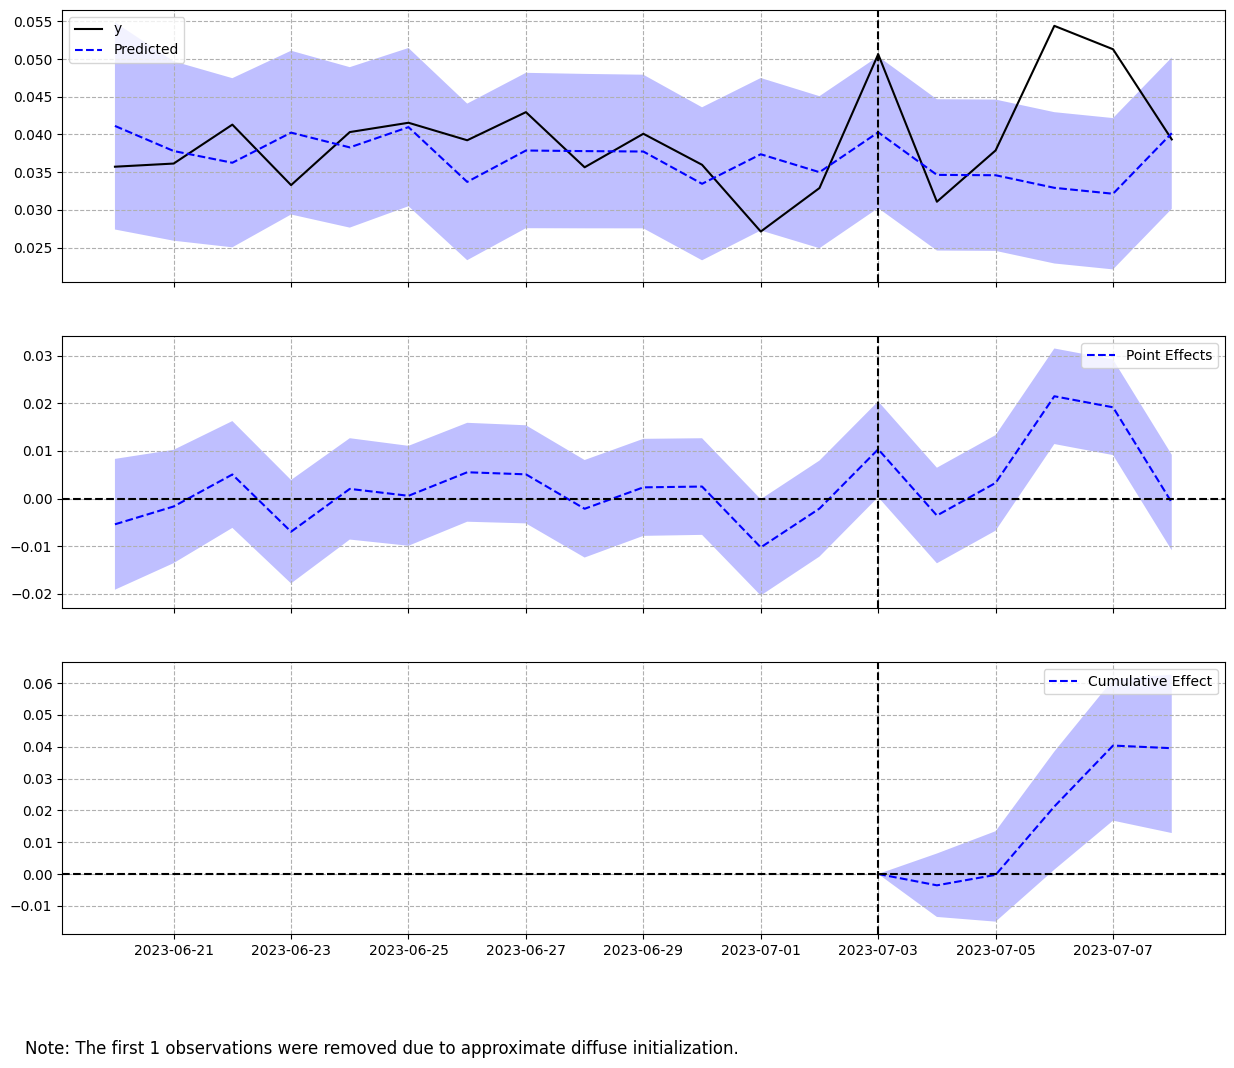

In [485]:
# Percentage of products PNA

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='perc_products_pna').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_perc_products_pna', 'Control_perc_products_pna']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_delivered_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_delivered_orders').reindex(columns=['Control'])
df_pivot['Control_avg_UIPO'] = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_perc_products_pna'
                                ,'Control_perc_products_pna'
                                ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model II: Average UIPO

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5.9. By contrast, in the absence of an
intervention, we would have expected an average response of 6.11.
The 95% interval of this counterfactual prediction is [5.94, 6.3].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -0.21 with a 95% interval of
[-0.4, -0.03]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 29.51.
By contrast, had the intervention not taken place, we would have expected
a sum of 30.56. The 95% interval of this prediction is [29.68, 31.52].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a

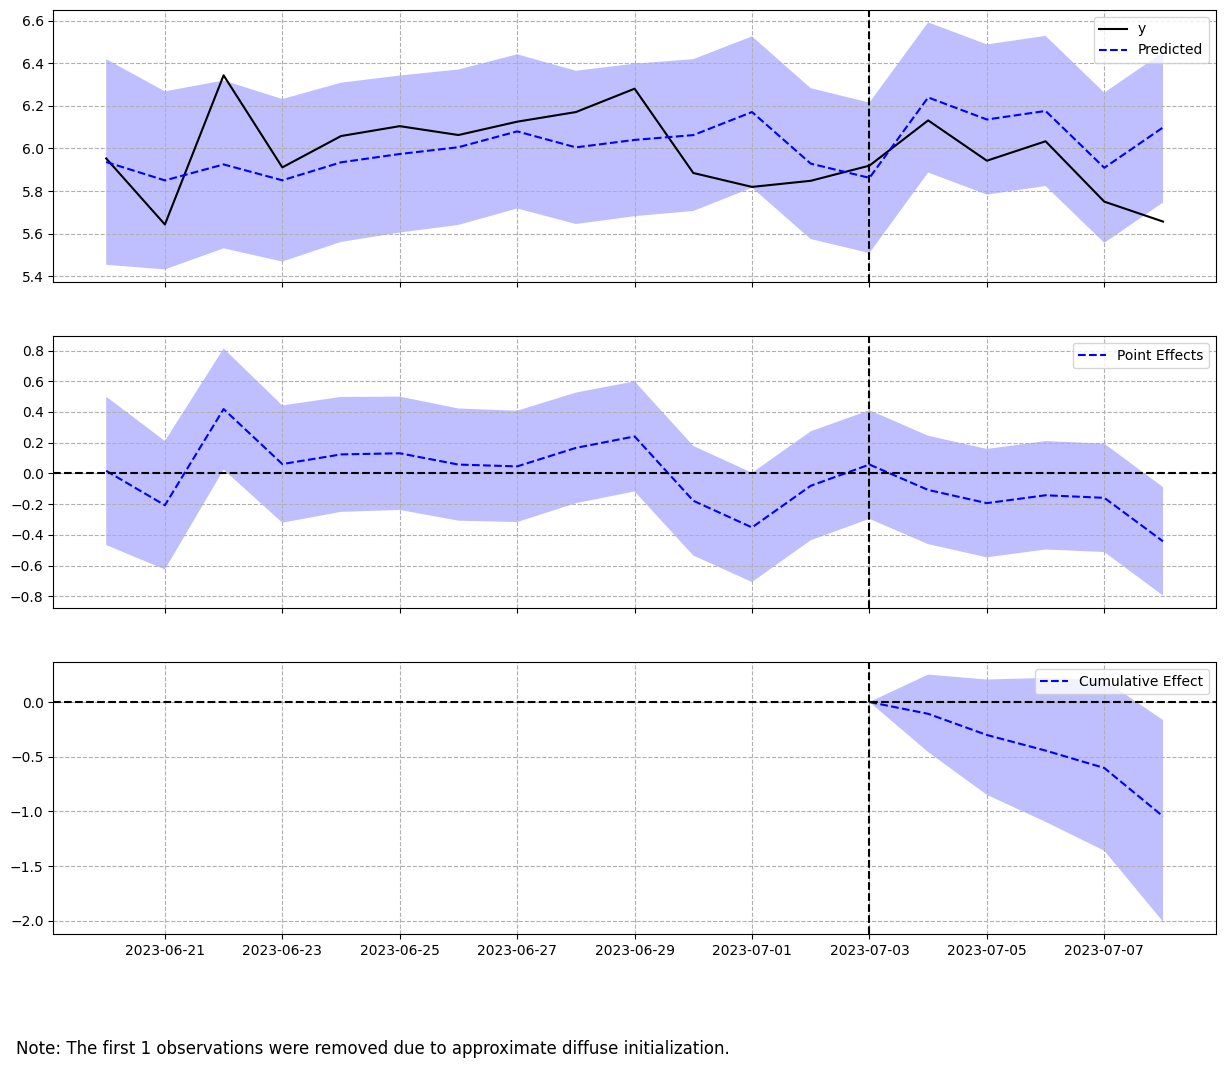

In [486]:
# Average UIPO

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='avg_UIPO').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_avg_UIPO', 'Control_avg_UIPO']  # Rename the first columns
df_pivot['Control_number_of_orders'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Control'])
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_avg_UIPO'
                            ,'Control_avg_UIPO'
                            ,'Control_number_of_orders'
                            ,'Control_total_quantity_placed']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()

Model III: Number of Orders

c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 352.0. By contrast, in the absence of an
intervention, we would have expected an average response of 444.39.
The 95% interval of this counterfactual prediction is [403.13, 485.22].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -92.39 with a 95% interval of
[-133.22, -51.13]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1760.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 2221.93. The 95% interval of this prediction is [2015.67, 2426.1].


The above results are given in terms of absolute numbers. In relative
terms, the respon

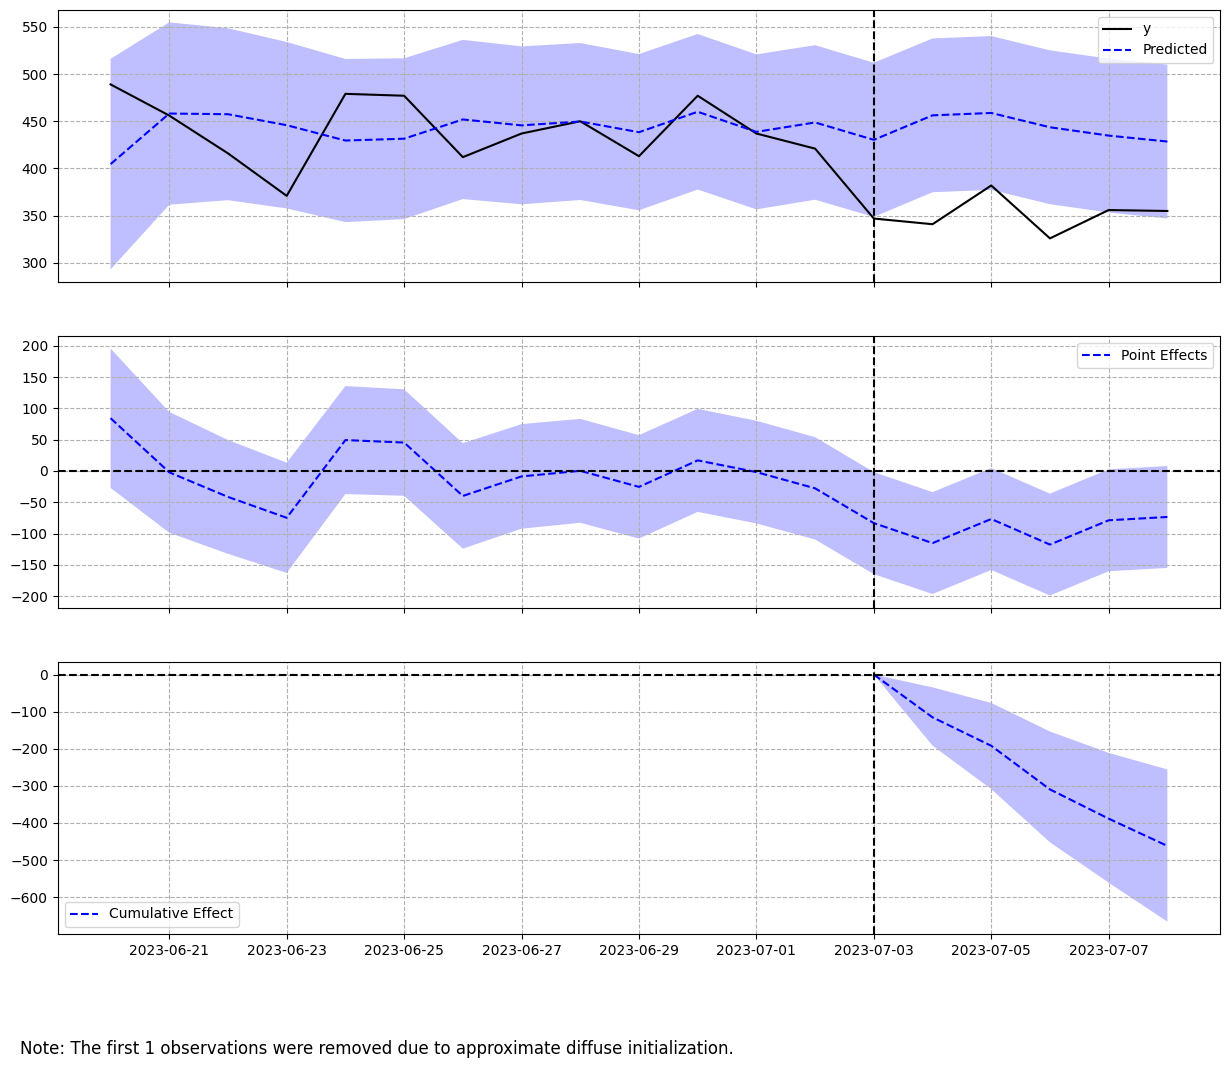

In [487]:
# Number of orders

# Pivot desired columns to conduct causalimpact analysis
df_pivot = df_synth_format.pivot(index='date', columns='Group', values='number_of_orders').reindex(columns=['Treat', 'Control'])
df_pivot.columns = ['Treat_number_of_orders', 'Control_number_of_orders']  # Rename the first columns
df_pivot['Control_number_of_products_with_pna'] = df_synth_format.pivot(index='date', columns='Group', values='number_of_products_with_pna').reindex(columns=['Control'])
df_pivot['Control_total_quantity_placed'] = df_synth_format.pivot(index='date', columns='Group', values='total_quantity_placed').reindex(columns=['Control'])
df_pivot['Control_products_value_placed'] = df_synth_format.pivot(index='date', columns='Group', values='products_value_placed').reindex(columns=['Control'])
df_pivot.index = pd.to_datetime(df_pivot.index) # Set the index in date format

# Model
df_input_model = df_pivot[['Treat_number_of_orders'
                            ,'Control_number_of_orders']]

model = ci.CausalImpact(df_input_model,pre_period,post_period)
print(model.summary('report'))
model.plot()